In [1]:
import dolfin as dl
import mshr

import numpy as np
import scipy.linalg as la

from scipy import interpolate
import scipy.stats as stats

from matplotlib import pyplot as plt


### Read in coordinates defining the FY-MY boundary

In [2]:
bndryCoords = np.genfromtxt('MY_boundary_coords.csv', delimiter=',')[1:,2:4]

### Read in the observed displacements

In [3]:
#dateStr = '_9Mar_0834_1600'
dateStr = '_10Mar_0037_12Mar_1648'
obsPos = np.genfromtxt('ReflDispl%s.csv'%dateStr,delimiter=',')[1:,1:]

obsLoc = np.vstack([obsPos[:,2:4], np.array([[0.0,0.0]])])
obsDisp = np.vstack([obsPos[:,2:4]-obsPos[:,0:2], np.array([[0.0,0.0]])])

nanBool = np.any(np.isnan(obsDisp), axis=1)

obsLoc = obsLoc[~nanBool,:]
obsDisp = obsDisp[~nanBool,:]

print(np.sqrt(obsDisp[:,0]**2 + obsDisp[:,1]**2))

[0.00082513 0.00265628 0.00821754 0.02467088 0.00351573 0.00301779
 0.00172088 0.00100879 0.00433093 0.00565531 0.00891408 0.02569787
 0.03811467 0.03007966 0.02388079 0.03802431 0.04058734 0.04994552
 0.0387622  0.00879525 0.00819265 0.00232914 0.        ]


### Define the Mesh
We will later want to extract degrees of freedom along the FY-MY boundary.  We therefore use `mshr` to created a mesh where the interface is maintained.

In [38]:
xmin, xmax = np.min(bndryCoords[:,0]), np.max(bndryCoords[:,0]) # Horizontal (east-west) extent of domain in meters
ymin, ymax = -915, 700 # Vertical (north-south) extent of domain in meters

Nx, Ny = 100,100 # Number of grid cells in horizontal and vertical directions

-650 850


In [5]:
bbox = mshr.Rectangle(dl.Point(xmin,ymin), dl.Point(xmax,ymax))

pts_fy = [dl.Point(xmin,ymin), dl.Point(xmax,ymin)] + [dl.Point(pt[0],pt[1]) for pt in bndryCoords[::-1,:]]
poly_fy = mshr.Polygon(pts_fy)

bbox.set_subdomain(1, poly_fy)

mesh = mshr.generate_mesh(bbox, 50)

Now plot the mesh and the subdomains to visually verify everything worked.

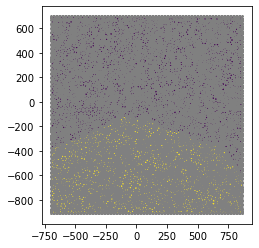

In [6]:
dl.plot(mesh)

cf = dl.MeshFunction("size_t", mesh, 2, mesh.domains())
dl.plot(cf)

plt.show()

We apply boundary conditions over two distinct sections of the domain boundary.  Homogeneous dirichlet boundary conditions are placed over much of the multiyear ice, while a spatially constant force is applied to much of the FY ice along the bottom boundary.  The follow two classes define these parts of the domain boundary.  Segments of the boundary that are not covered by these classes are given stress-free boundary conditions.

In [7]:
# Define boundary classes
class FixedDomain(dl.SubDomain):
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]>self.bndryInterp(x[0]))
    
class LoadBoundary(dl.SubDomain):
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]<=self.bndryInterp(x[0]))


### Define the ice mechanical properties

In [8]:
thick_fy = 1 # Thickness of first year ice in meters
thick_my = 4 # Thickness of multiyear ice in meters

youngsModulus_fy = 6e9 # Young's modulus for first year ice [Pascals]
youngsModulus_my = 9e9 # Young's modulus for multiyear ice [Pascals]

poissonRatio = 0.3 # Poisson ratio for all ice

Using the prescribed Young's modulus and Poisson ratio, we can now compute the Lam&#233; parameters for the FY and MY ice types.

In [9]:
lmbda_fy = youngsModulus_fy*poissonRatio/((1.0+poissonRatio)*(1.0-2.0*poissonRatio))
mu_fy    = youngsModulus_fy/(2.0*(1.0+poissonRatio))

lmbda_my = youngsModulus_my*poissonRatio/((1.0+poissonRatio)*(1.0-2.0*poissonRatio))
mu_my    = youngsModulus_my/(2.0*(1.0+poissonRatio))

The following classes defines the spatially varying Lame parameters used later on in the weak form.

In [10]:
class IceProperty(dl.UserExpression):
    """ Defines a property of the ice (like a Lame parameter) 
        that depends on whether the ice is first year ice or 
        multiyear ice.  The value of the parameter within each 
        ice type is constant.
    """
    
    def __init__(self, bndryCoords, val_fy, val_my, **kwargs):
        """
        Args:
            bndryCoords (np.array): A two column numpy array containing
                                    points on the boundary between first 
                                    year and multiyear ice.  This class 
                                    assumes that ice below this boundary 
                                    is first year and ice above this boundary
                                    is multiyear.  In the future, a more
                                    flexible definition of FY and MY domains
                                    might be necessary.
            val_fy (float): The value of the ice property for FY ice.
            val_my (float): The value of the ice property for MY ice.
            
        """
        super().__init__(**kwargs)
        self.bndryCoords = bndryCoords
        self.val_fy = val_fy
        self.val_my = val_my
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def eval(self, value, x):
        
        # First, figure out if we're below or about the FY-MY boundary
        bndry_y = self.bndryInterp(x[0])
        
        # The point is below the boundary, so use the FY value
        if(x[1]<bndry_y):
            value[0] = self.val_fy
        else:
            value[0] = self.val_my
            
#     def value_shape(self):
#         return (1,)


### Define the boundary conditions

In [11]:
# Dirichlet BC
u_bndry = dl.Constant((0.0,0.0)) # x,y components of displacement in meters

In [12]:
class BoundaryLoad(dl.UserExpression):
    
    def eval(selv,values, x):
        
        scale = 1e6
            
        values[0] = -scale*((x[0]-100.)/1400.)
        values[1] = scale
        
    def value_shape(self):
        return (2,)

In [13]:
f_bndry = BoundaryLoad()

### Set up the variational problem

In [14]:
# Define the necessary function space
V = dl.FunctionSpace(mesh, "Lagrange", 1) # scalar function space
W = dl.VectorFunctionSpace(mesh, "Lagrange", 1) # vector function space
S = dl.TensorFunctionSpace(mesh, "DG", 0) # tensor function space

# Initialize sub-domain instances
fixedDomain = FixedDomain(bndryCoords)
loadBndry = LoadBoundary(bndryCoords)

# Mark boundary domains
boundaries = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundaries.set_all(0)
loadBndry.mark(boundaries, 1)

# Define measures of exterior boundaries
ds = dl.Measure("ds", domain=mesh, subdomain_data=boundaries)

# Define mechanical dirichlet boundary condition
fixed_bc = dl.DirichletBC(W, u_bndry, fixedDomain)

# Trial functions
u = dl.TrialFunction(W) # displacement

# Test functions
w = dl.TestFunction(W)

# Total strain
eps = dl.sym(dl.grad(u))

lbda = IceProperty(bndryCoords=bndryCoords, val_fy=lmbda_fy, val_my=lmbda_my)
mu = IceProperty(bndryCoords=bndryCoords, val_fy=mu_fy, val_my=mu_my)
thick = IceProperty(bndryCoords=bndryCoords, val_fy=thick_fy, val_my=thick_my)

# Stress
sigma = lbda*dl.Identity(2)*dl.tr(eps) + 2*mu*eps

# Linear elastic weak form
G = dl.inner(dl.grad(w), thick*sigma)*dl.dx - dl.dot(w,f_bndry)*ds(1)

# Prepare solution function and solver for mechanical problem
u = dl.Function(W)
problem_u = dl.LinearVariationalProblem(dl.lhs(G), dl.rhs(G), u, fixed_bc)
solver_u  = dl.LinearVariationalSolver(problem_u)

solver_u.solve()

ofile = dl.File("Displacement.pvd")
ofile << u


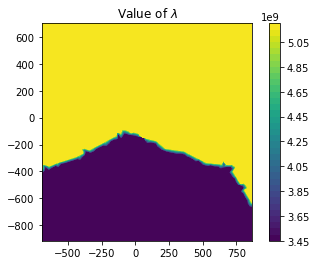

In [15]:
lbda_func = dl.interpolate(lbda,V)
c=dl.plot(lbda_func,title='Value of $\lambda$')
plt.colorbar(c)
plt.show()

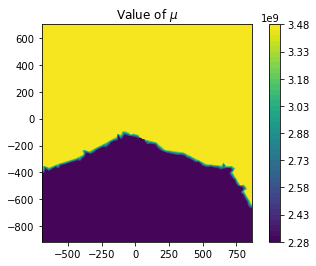

In [16]:
mu_func = dl.interpolate(mu,V)
c= dl.plot(mu_func,title='Value of $\mu$')
plt.colorbar(c)
plt.show()

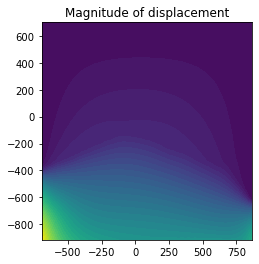

In [17]:
u_mag = dl.sqrt(dl.dot(u,u))
u_mag = dl.project(u_mag,V)
dl.plot(u_mag,title='Magnitude of displacement')

In [18]:
stiffMat = dl.assemble(dl.lhs(G))

In [19]:
class MYBndry(dl.SubDomain):
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]>self.bndryInterp(x[0]))
    
class FYBndry(dl.SubDomain):
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]<self.bndryInterp(x[0]))
    
# class SharedInterface(dl.SubDomain):
#     def __init__(self, bndryCoords, **kwargs):
#         super().__init__(**kwargs)
        
#         # Set up the 1d interpolation function
#         self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
#     def inside(self, x, on_boundary):
#         return dl.near(x[1],self.bndryInterp(x[0]))
    
def GetDofIndices(W, mesh):
    """
    Returns the indices of the DOFs on each part of the boundary: 
        (1) the outside of the multiyear ice, 
        (2) the outside of the first year ice, and 
        (3) the intersection of the FY and MY ice.
        
    The result is a list of tuples containing the indices of the
    x displacement and y displacement for each DOF on these boundaries.
    
    """
    
    my_bndry = MYBndry(bndryCoords)
    fy_bndry = FYBndry(bndryCoords)
    #shared_bndry = SharedInterface(bndryCoords)
    
    temp = dl.Function(W)
    bc_my = dl.DirichletBC(W, dl.Constant((1,1.5)), my_bndry)
    bc_my.apply(temp.vector())
    
    bc_fy = dl.DirichletBC(W, dl.Constant((2,2.5)), fy_bndry)
    bc_fy.apply(temp.vector())
    
    #bc_shared = dl.DirichletBC(W, dl.Constant((3,3.5)), shared_bndry)
    #bc_shared.apply(temp.vector())
    
    my_dofs_x = np.where(temp.vector()==1)[0]
    my_dofs_y = np.where(temp.vector()==1.5)[0]
    
    fy_dofs_x = np.where(temp.vector()==2)[0]
    fy_dofs_y = np.where(temp.vector()==2.5)[0]
    
    #shared_dofs_x = np.where(temp.vector()==3)[0]
    #shared_dofs_y = np.where(temp.vector()==3.5)[0]
    
    return (my_dofs_x,my_dofs_y), (fy_dofs_x, fy_dofs_y)

    #return (my_dofs_x,my_dofs_y), (fy_dofs_x, fy_dofs_y), (shared_dofs_x, shared_dofs_y)



In [20]:
dofs_my, dofs_fy = GetDofIndices(W,mesh)
all_dofs = np.concatenate([dofs_my[0], dofs_my[1], dofs_fy[0], dofs_fy[1]])

num_my = len(dofs_my[0])
num_fy = len(dofs_fy[0])
#num_sh = len(dofs_shared[0])
num_bc_dofs = len(all_dofs)

my_inds = [i for i in range(2*num_my)]
fy_inds = [my_inds[-1] + 1 + i for i in range(2*num_fy)]
#sh_inds = [fy_inds[-1] + 1 + i for i in range(2*num_sh)]

In [21]:
from petsc4py import PETSc

def ConstructObservationMatrix(W, mesh, nodes):
    """ Constructs a matrix that, when applied to the displacement vector 
        on the entire mesh, returns the values of the displacement at the specified nodes.
        
        INPUTS:
            W : The vector-valued function space.
            nodes: An Nx2 numpy array containing the x and y locations of the observation points.
        
    """
    mesh = W.mesh()
    el = W.element()
    
    num_nodes = nodes.shape[0]
    num_dofs = mesh.num_vertices()
    
    dim = nodes.shape[1]
    
    num_rows = dim*num_nodes
    num_cols = dim*num_dofs
    
    A = np.zeros((num_rows, num_cols))
    row_ind = 0
    for pt in nodes:
        cellId, distance = mesh.bounding_box_tree().compute_closest_entity(dl.Point(pt))
        cell = dl.Cell(mesh, cellId)
    
        coordinate_dofs = cell.get_vertex_coordinates()
        
        values = el.evaluate_basis_all(np.array(pt), coordinate_dofs, cell.orientation())
        
        dofs = np.array(W.dofmap().cell_dofs(cellId))
        dofs_per_component = int(len(dofs)/dim)
        
        # Fill in the observation matrix
        for d in range(dim):
            for dof_ind in range(dofs_per_component):
                col_ind = dofs[d*dofs_per_component + dof_ind]
                A[row_ind,col_ind] = values[d*(1+dofs_per_component*dim) + dof_ind*dim]
            row_ind += 1 
            
    return A

let $u_{obs}$ the vector of displacements at the reflector positions and let $u_{bc}$ denote the vector of coefficients at each degree of freedom on the boundary of the domain $\partial \Omega$ or at the interface of the first year and multiyear ice.   One way to impose boundary conditions is to take the stiffness matrix defined without any Dirichlet boundary conditions $K$ and add a large value along the diagonal to degrees of freedom that correspond to the dirichlet boundary.  Let $I_{bc}$ denote a diagonal matrix containing ones for Dirichlet boundary degrees of freedom and zeros everywhere else.   Let $\alpha$ denote a large value (e.g., $10^20$).  The displacement field resulting from approximate imposition of the Dirichlet boundary conditions is then given by

$$
u = \alpha(\alpha I_{bc} + K)^{-1} u_{bc},
$$
where $u_{bc}$ is a vector that is only nonzero at boundary degrees of freedom.  A matrix $B$ can also be constructed to obtain the displacements at the observation point.
$$
u_{obs} = B(\alpha I_{bc} + K)^{-1} u_{bc}
$$

In [22]:
B = ConstructObservationMatrix(W, mesh, obsLoc)
K = stiffMat.array()

# Enforce Dirichlet conditions
for i in all_dofs:
    K[i,:] = 0
    K[i,i] = 1.0

num_dofs = K.shape[0]

#kinv = la.solve(K,np.eye(K.shape[0]))
temp = la.solve(K, B.T, transposed=True).T

H = temp[:, all_dofs]
#kinv = kinv[:,all_dofs]

In [23]:
# Get coordinates as len(dofs) x gdim array
all_locs = W.tabulate_dof_coordinates()

from sklearn.metrics import pairwise_distances

failStress = 2e6 # failure stress in pascals

fyStrain = 2e-4 #2e-5 # failure strain based on failStress and FY Young's 
myStrain = 4e-5 #failStress / youngsModulus_my/thick_my # 5e-6


myStd_x = 0.5*myStrain*np.sqrt(np.sum(all_locs[dofs_my[0]]**2,axis=1)) # 0.5 to account for 95% CI
myStd_y = 0.5*myStrain*np.sqrt(np.sum(all_locs[dofs_my[1]]**2,axis=1))
fyStd_x = 0.5*fyStrain*np.sqrt(np.sum(all_locs[dofs_fy[0]]**2,axis=1))
fyStd_y = 0.5*fyStrain*np.sqrt(np.sum(all_locs[dofs_fy[1]]**2,axis=1))

                              
L = 100.0
crossScale = 0.0
# my_var = 5e-3*5e-3
# fy_var = 1e-2*1e-2

# Compute the distance matrix and give dofs on different boundaries or coordinates infinite distance
priorCov = np.zeros((num_bc_dofs,num_bc_dofs))

# MY x-direction
priorCov[my_inds[0]:my_inds[num_my-1]+1,my_inds[0]:my_inds[num_my-1]+1] = (myStd_x**2)*np.exp(-(pairwise_distances(all_locs[dofs_my[0]])**2)/(L**2))

# MY y-direction
priorCov[my_inds[num_my]:my_inds[-1]+1,my_inds[num_my]:my_inds[-1]+1] = (myStd_y**2)*np.exp(-(pairwise_distances(all_locs[dofs_my[1]])**2)/(L**2))

# FY x-direction
priorCov[fy_inds[0]:fy_inds[num_fy-1]+1,fy_inds[0]:fy_inds[num_fy-1]+1] = (fyStd_x**2)*np.exp(-(pairwise_distances(all_locs[dofs_fy[0]])**2)/(L**2))

# FY y-direction
priorCov[fy_inds[num_fy]:fy_inds[-1]+1,fy_inds[num_fy]:fy_inds[-1]+1] = (fyStd_y**2)*np.exp(-(pairwise_distances(all_locs[dofs_fy[1]])**2)/(L**2))

# FY-MY cross in x
priorCov[fy_inds[0]:fy_inds[num_fy-1]+1,my_inds[0]:my_inds[num_my-1]+1] = crossScale*np.outer(fyStd_x,myStd_x)*np.exp(-(pairwise_distances(all_locs[dofs_fy[0]], all_locs[dofs_my[0]])**2)/(L**2))
priorCov[my_inds[0]:my_inds[num_my-1]+1,fy_inds[0]:fy_inds[num_fy-1]+1] = priorCov[fy_inds[0]:fy_inds[num_fy-1]+1,my_inds[0]:my_inds[num_my-1]+1].T

# FY-MY cross in y
priorCov[fy_inds[num_fy]:fy_inds[-1]+1,my_inds[num_my]:my_inds[-1]+1] = crossScale*np.outer(fyStd_y,myStd_y)*np.exp(-(pairwise_distances(all_locs[dofs_fy[1]],all_locs[dofs_my[1]])**2)/(L**2))
priorCov[my_inds[num_my]:my_inds[-1]+1,fy_inds[num_fy]:fy_inds[-1]+1] = priorCov[fy_inds[num_fy]:fy_inds[-1]+1,my_inds[num_my]:my_inds[-1]+1].T

### Construct noise covariance
The laser observing system used here has different noise levels in radial and tangential direction (relative to the laser position at $(0,0)$).   The reported error in the range (radial direction) is 0.6mm +1mm/km.  The reported error in the angular measurement is $2.7\times 10^{-4}$ degrees.  It is also expected that field performance is lower than these values to to atmospheric effects and data processing techniques.

Let $r$ be the range measurement with standard deviation $\sigma_r$ and let $\theta$ be the angular measurement with standard deviation $\sigma_\theta$.  These are related to the cartesian coordinates $(x,y)$ through 
$$
\left[\begin{array}{c}x\\y\end{array} \right] = \left[\begin{array}{c} r\cos(\theta)\\ r \sin(\theta)\end{array}\right].
$$
We now turn to propagating errors in the range and angle into correlated errors in the cartesian coordinates. We assume the observed range is given by $r_{\text{obs}} = \bar{r}+(\sigma_r+\alpha_r\bar{r})z_r$, where $\bar{r}$ is the true range and $z_r$ is a standard normal random variable.   Using the manufacturer-reported errors, the values of $\sigma_r$ and $\alpha_r$ would be $0.6$mm and $1$mm/km, respectively.  The observed angle is similarly defined, but without the multipliciative term: $\theta_{\text{obs}} = \bar{\theta} + \sigma_\theta z_\theta$.  Using these definitions, the observed cartesian coordinates are given by 
$$
\left[\begin{array}{c}x_{\text{obs}}\\y_{\text{obs}}\end{array} \right] = \left[\begin{array}{c} \left(\bar{r}+(\sigma_r+\alpha_r\bar{r})z_r\right)\cos\left(\bar{\theta}+\sigma_\theta z_\theta\right)\\ \left(\bar{r}+(\sigma_r+\alpha_r\bar{r})z_r\right)\sin\left(\bar{\theta}+\sigma_\theta z_\theta\right)\end{array}\right].
$$
The mapping from $(z_r,z_\theta)$ to $(x_{\text{obs}}, y_{\text{obs}})$ is nonlinear and the joint distribution of the Cartesian coordinaates $(x_{\text{obs}}, y_{\text{obs}})$ is therefore non-Gaussian.  To simplify computation, we will instead use a Gaussian approximation based on a linear approximation of the $(z_r,z_\theta)\rightarrow (x_{\text{obs}}, y_{\text{obs}})$ mapping.   The Jacobian of the transformation with respect to $(z_r, z_\theta)$ evaluated at $(0,0)$ is given by
$$
J = \left[\begin{array}{cc}
(\sigma_r+\alpha_r\bar{r})\cos\left(\bar{\theta}\right) & -\sigma_\theta \bar{r}\sin(\bar{\theta}) \\
(\sigma_r+\alpha_r\bar{r})\sin\left(\bar{\theta}\right) & \sigma_\theta \bar{r}\cos(\bar{\theta})\end{array}\right],
$$

$$
(x_{\text{obs}}, y_{\text{obs}}) \sim N(\mu, \Sigma),
$$
with 
$$
\mu = \left[\begin{array}{c}\bar{x}\\ \bar{y}\end{array}\right] = \left[\begin{array}{c}\bar{r}\cos(\bar{\theta})\\ \bar{r}\sin(\bar{\theta}) \end{array}\right]
$$
and
$$
\Sigma = JJ^T.
$$
Notice that the Jacobian $J$ depends on the mean range $\bar{r}$, which is our model output.  This multiplicative term would result in a non-Gaussian posterior distribution that cannot be characterized analytically.   To leverage efficient Gaussian calculations, we will again make an additional approximation and use the observed range to define the covariance $\Sigma$ so that $\Sigma$ does not depend on the unknown true range $\bar{r}$.

In [24]:
obsCov = np.zeros((H.shape[0], H.shape[0]))

sigma_r = 6e-4 # base noise std. dev. in meters
alpha_r = 1e-6 # multiplicative factor in m/m
sigma_theta = 2.7e-4 * np.pi/180 # angular std. dev. in radians

for i in range(obsLoc.shape[0]):
    rObs = np.sqrt(obsLoc[i,0]**2 + obsLoc[i,1]**2)
    thetaObs = np.arctan2(obsLoc[i,1],obsLoc[i,0])
    J = np.array([[(sigma_r + alpha_r*rObs)*np.cos(thetaObs), -sigma_theta*rObs*np.sin(thetaObs)],
                  [(sigma_r + alpha_r*rObs)*np.sin(thetaObs), sigma_theta*rObs*np.cos(thetaObs)]])
    obsCov[2*i:2*i+2, 2*i:2*i+2] = J@J.T

obsCov[-2:,-2:] = 1e-14*np.eye(2)

In [25]:
print("Noise Std. Dev.:")
print(np.sqrt(np.diag(obsCov)))

Noise Std. Dev.:
[8.55221620e-04 7.81631569e-04 8.16463111e-04 8.02646849e-04
 1.54589247e-03 1.30279513e-03 2.54581251e-03 1.61194671e-03
 1.94875118e-03 2.69072528e-03 1.29776376e-03 2.65037286e-03
 1.60410148e-03 2.46418540e-03 1.32786200e-03 1.15184876e-03
 1.91660034e-03 1.20369680e-03 1.35571544e-03 1.25352100e-03
 1.82830082e-03 1.96980903e-03 2.74335258e-03 1.88842187e-03
 3.21356807e-03 1.66176927e-03 2.57113295e-03 1.20112277e-03
 2.17711089e-03 1.11691003e-03 3.27240534e-03 1.32384200e-03
 3.19911974e-03 1.36672096e-03 4.07391572e-03 1.80866021e-03
 3.45182963e-03 2.61456487e-03 1.82160694e-03 2.77838437e-03
 1.28771441e-03 3.22012379e-03 8.63134355e-04 1.12358248e-03
 1.00000000e-07 1.00000000e-07]


In [26]:
priorMu = np.zeros((H.shape[1]))

# Compute the posterior mean.
crossCov = H@priorCov
predCov = crossCov@H.T + obsCov
kalmanGain = la.solve(predCov,crossCov).T
postMu = priorMu + kalmanGain@(obsDisp.ravel())

postCov = priorCov - kalmanGain @ crossCov

resid = H@postMu - obsDisp.ravel()
resid_x = resid[0::2]
resid_y = resid[1::2]
error = np.sqrt(resid_x**2 + resid_y**2)

print(np.abs(resid)/np.sqrt(np.diag(obsCov)))
print('Maximum error = %0.3e'%np.max(error))
print('Average error = %0.3e'%np.mean(error))

dispMag = np.sqrt(obsDisp[:,0]**2 + obsDisp[:,1]**2)

[5.49066447e-01 1.61379044e+00 5.85451797e-01 1.88258078e-01
 1.42442056e+00 2.05777606e+00 3.26342042e-01 1.12996891e-01
 8.64148178e-02 1.22580686e-01 7.80860560e-01 6.59643522e-01
 4.78097498e-01 9.64428394e-02 9.85790967e-02 1.09191056e+00
 5.97233667e-02 8.13105159e-02 2.92821271e-01 3.28062719e-01
 5.51572467e-01 6.38564575e-01 1.32510958e+00 1.47614530e+00
 3.37061771e-01 2.46697095e-01 7.05512179e-01 3.34542162e-01
 5.84937906e-01 2.13172339e-01 3.30918783e-01 6.01931995e-02
 7.65868825e-02 2.61668589e-01 2.20459074e-01 9.55021839e-02
 4.18514489e-01 4.34221391e-01 3.59446923e-01 6.60926925e-01
 3.91098649e-03 7.05857266e-01 1.48425584e-01 5.78940435e-01
 2.03850641e-05 4.18475905e-04]
Maximum error = 4.581e-03
Average error = 1.348e-03


In [27]:
print('Maximum Boundary Displacement (x): ', np.max(np.abs(postMu[0::2])))
print('Maximum Boundary Displacement (y): ', np.max(np.abs(postMu[1::2])))
print('Maximum Observed Displacement (x): ', np.max(np.abs(obsDisp[:,0])))
print('Maximum Observed Displacement (y): ', np.max(np.abs(obsDisp[:,1])))


Maximum Boundary Displacement (x):  0.08770127898782949
Maximum Boundary Displacement (y):  0.08540779131730407
Maximum Observed Displacement (x):  0.012947183406311069
Maximum Observed Displacement (y):  0.049665454862179104


### Posterior predictive check

In [28]:
postPredMu = H@postMu
postPredCov = H@postCov@H.T + obsCov
postPredCov = 0.5*(postPredCov + postPredCov.T)

# Whiten the observation
L = la.cholesky(postPredCov[0::-2,0::-2])
z = la.solve(L, obsDisp[0:-1,:].ravel()-postPredMu[0:-2])

T1 = np.sum(z**2)
print('P value: ', 1.0-stats.chi2.cdf(T1, df=len(z)))


P value:  0.0012965330048717583


In [29]:
temp = np.zeros((K.shape[1]))
temp[all_dofs] = postMu

u = dl.Function(W)
u.vector().set_local(la.solve(K,temp))

eps = dl.project( dl.sym(dl.grad(u)), S)
sigma = dl.project(lbda*dl.Identity(2)*dl.tr(eps) + 2*mu*eps, S)

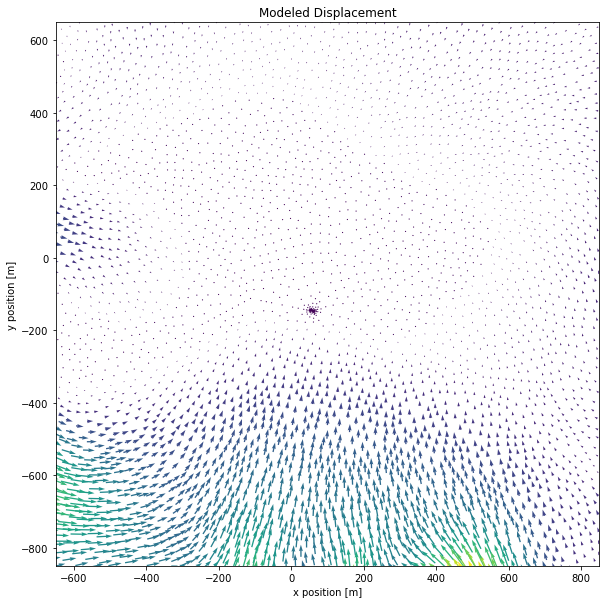

In [36]:
plt.figure(figsize=(10,10))
dl.plot(u)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Modeled Displacement')
plt.xlim(-650,850)
plt.ylim(-850,650)
plt.show()

In [31]:
ofile = dl.File("Displacement%s.pvd"%dateStr)
ofile << u

ofile = dl.File("Strain%s.pvd"%dateStr)
ofile << eps

ofile = dl.File("Stress%s.pvd"%dateStr)
ofile << sigma